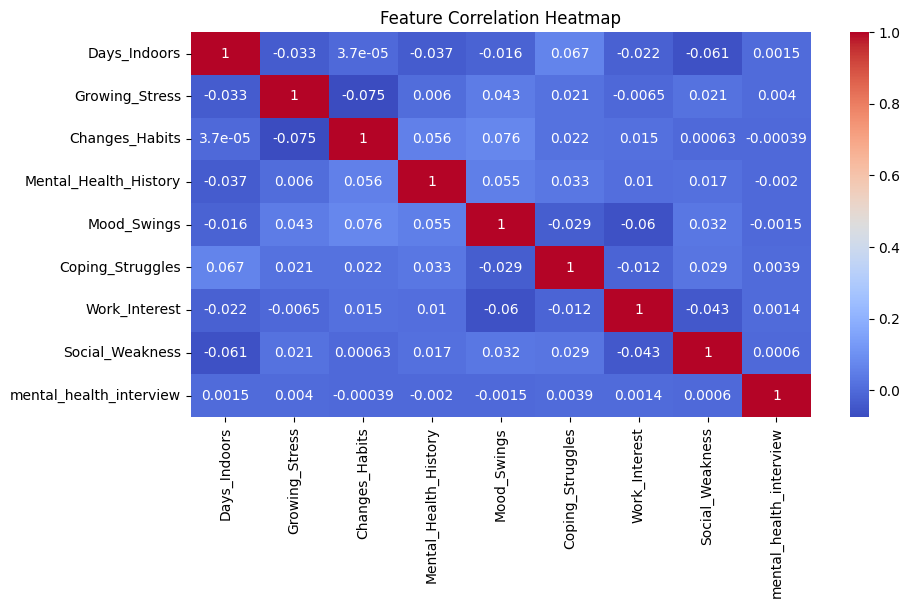

Preprocessing complete. Cleaned data saved as 'cleaned_mental_health_data1.csv'.


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Load dataset
df = pd.read_csv(r"C:\Users\DELL\Downloads\Dataset.csv")

# 🔹 Step 1: Remove Unnecessary Columns
columns_to_remove = ["Timestamp","Gender","Country","Occupation","self_employed","family_history","treatment","Days_Indoor","care_options"]  # Replace with actual column names to drop
df = df.drop(columns=[col for col in columns_to_remove if col in df.columns])  # Drop only existing columns
# Handle Missing Values
imputer = SimpleImputer(strategy='most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

# Encode Categorical Variables
label_encoders = {}
for col in df_imputed.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df_imputed[col] = le.fit_transform(df_imputed[col])
    label_encoders[col] = le  # Store encoder for future use

# Basic EDA
plt.figure(figsize=(10, 5))
sns.heatmap(df_imputed.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

# Save Cleaned Data
df_imputed.to_csv('cleaned_mental_health_data1.csv', index=False)
print("Preprocessing complete. Cleaned data saved as 'cleaned_mental_health_data1.csv'.")


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer  
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Load the cleaned dataset
df = pd.read_csv("cleaned_mental_health_data1.csv")
condition= "Mood_Swings"

# Encode categorical labels
label_encoder = LabelEncoder()
df[condition] = label_encoder.fit_transform(df[condition])  # Assuming 'condition' is the target column

# Splitting data
X = df.drop(columns=[condition])  # Features
y = df[condition]  # Target
df[condition] = label_encoder.fit_transform(df[condition])  # Assuming 'condition' is the target column
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing numerical features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save scaler
joblib.dump(scaler, "scaler.pkl")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Get feature importance and select top 8 features
importances = rf.feature_importances_
top_features_idx = np.argsort(importances)[-8:]  # Select top 8 features
top_feature_names = X.columns[top_features_idx]  # Get feature names

# Reduce dataset to top 8 features
X_train_selected = X_train[:, top_features_idx]
X_test_selected = X_test[:, top_features_idx]


# Model training function
def train_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    print(f"\n{name} Performance:")
    print(classification_report(y_test, y_pred))
    
    return accuracy_score(y_test, y_pred), model

# Train models
logreg_acc, logreg_model = train_model(LogisticRegression(), "Logistic Regression")
rf_acc, rf_model = train_model(RandomForestClassifier(n_estimators=100), "Random Forest")
xgb_acc, xgb_model = train_model(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'), "XGBoost")

# Select the best model
models = {"Logistic Regression": logreg_acc, "Random Forest": rf_acc, "XGBoost": xgb_acc}
best_model_name = max(models, key=models.get)

if best_model_name == "Logistic Regression":
    best_model = logreg_model
elif best_model_name == "Random Forest":
    best_model = rf_model
else:
    best_model = xgb_model

# Save the best model
joblib.dump(best_model, "mental_health_model.pkl")
print(f"\nBest Model: {best_model_name} saved as 'mental_health_model.pkl'")
joblib.dump(scaler,"scaler.pkl")
print(" e scaler saved as'scaler.pkl'")
condition_mapping = dict(enumerate(label_encoder.classes_))
joblib.dump(condition_mapping,"condition_mapping.pkl")
print("condition_mapping saved as 'condition_mapping.pkl'")


Logistic Regression Performance:
              precision    recall  f1-score   support

           0       0.36      0.26      0.30     18112
           1       0.38      0.40      0.39     20120
           2       0.39      0.45      0.42     20241

    accuracy                           0.38     58473
   macro avg       0.37      0.37      0.37     58473
weighted avg       0.37      0.38      0.37     58473


Random Forest Performance:
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     18112
           1       0.94      0.92      0.93     20120
           2       0.91      0.93      0.92     20241

    accuracy                           0.92     58473
   macro avg       0.93      0.92      0.92     58473
weighted avg       0.92      0.92      0.92     58473



C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:48:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Performance:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93     18112
           1       0.94      0.92      0.93     20120
           2       0.90      0.94      0.92     20241

    accuracy                           0.93     58473
   macro avg       0.93      0.92      0.93     58473
weighted avg       0.93      0.93      0.93     58473


Best Model: XGBoost saved as 'mental_health_model.pkl'
 e scaler saved as'scaler.pkl'
condition_mapping saved as 'condition_mapping.pkl'


In [7]:
import joblib
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Load the trained model
model = joblib.load("mental_health_model.pkl")

# Load the same scaler used during training
scaler = joblib.load("scaler.pkl")  # Make sure to save the scaler during training

# Define symptoms for user input
symptom_list = [
    "Growing_Stress","Changes_Habits","Mental_Health_History","Mood_Swings","Coping_Struggels","Work_Interest","Social_Weaknes","mental_health_interview"
]  # Modify based on dataset features

def get_user_input():
    """Collect user symptoms and convert to numerical format"""
    print("\nEnter your symptoms (0 for No, 1 for Yes):")
    user_input = []
    for symptom in symptom_list:
        while True:
            try:
                val = int(input(f"Do you experience {symptom.replace('_', ' ')}? (0/1): "))
                if val in [0, 1]:
                    user_input.append(val)
                    break
                else:
                    print("Invalid input! Enter 0 (No) or 1 (Yes).")
            except ValueError:
                print("Invalid input! Enter a number.")

    return np.array(user_input).reshape(1, -1)

def predict_mental_health():
    """Make predictions based on user symptoms"""
    user_data = get_user_input()
    user_data = scaler.transform(user_data)  # Apply same transformation

    prediction = model.predict(user_data)[0]
    
    # Load condition mapping (ensure it's saved during training)
    condition_mapping = joblib.load("condition_mapping.pkl")
    predicted_condition = condition_mapping[prediction]

    print(f"\n🧠 Predicted Mental Health Condition: {predicted_condition}")

if __name__ == "__main__":
    predict_mental_health()


Enter your symptoms (0 for No, 1 for Yes):


Do you experience Growing Stress? (0/1):  1
Do you experience Changes Habits? (0/1):  1
Do you experience Mental Health History? (0/1):  1
Do you experience Mood Swings? (0/1):  1
Do you experience Coping Struggels? (0/1):  1
Do you experience Work Interest? (0/1):  1
Do you experience Social Weaknes? (0/1):  1
Do you experience mental health interview? (0/1):  1



🧠 Predicted Mental Health Condition: 2


C:\Users\DELL\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
